In [7]:
import pandas as pd
import csv as csv
import os
import pickle
from collections import Counter

import numpy as np
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score, KFold
from sklearn.manifold import TSNE, Isomap, SpectralEmbedding
from metric_learn import LMNN, ITML_Supervised, LSML_Supervised, SDML_Supervised
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder,OneHotEncoder

import xgboost as xgb

train_data_path = './titanic/train.csv'
test_data_path = './titanic/test.csv'
save_path = './titanic/{}.bin'
output_path = './titanic/submit_data.csv'
alphabet_list = 'a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u,v,w,x,y,z'.split(',')
columns = ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Embarked', 'Title', 'Cabin', 'Fare', 'FamilySize', 'IsAlone', 'NameLength', 'TicketPre', 'TicketNum'] + alphabet_list
pp_columns_age = ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Title', 'Fare', 'FamilySize', 'IsAlone', 'NameLength'] + alphabet_list
pp_columns_cabin = ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Embarked', 'Title', 'Cabin', 'Fare', 'FamilySize', 'IsAlone', 'TicketPre', 'TicketNum']
categorical_column = [columns.index(name) - 1 for name in ['Sex', 'Embarked', 'Title', 'Cabin', 'TicketPre']]
objective_variable_name = 'Survived'
pp_objective_variable_name_age = 'Age'
pp_objective_variable_name_cabin = 'Cabin'
id_name = 'PassengerId'

def data_frame_processing(df: 'DataFrame') -> 'DataFrame':
    df['Cabin'] = df['Cabin'].map(lambda x: str(x)[0] if x else x)
    # name process
    df['Title'] = df.Name.str.extract(r' ([A-Za-z]+)\.', expand=False)
    df['Title'] = df['Title'].replace(
        ['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    df['Title'] = df['Title'].replace('Mlle', 'Miss')
    df['Title'] = df['Title'].replace('Ms', 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')

    # fitting Name to category distribution of alphabet
    prep_name_alphabet_category = df.Name.str \
        .extract(r'([A-Za-z\(\)]+)?,\s[A-Za-z]+\.([\(\)\sA-Za-z]+)', expand=False) \
        .apply(lambda x: '{0}{1}'.format(x[0], x[1]).lower(), axis=1) \
        .str.replace(r'[\s\(\)]', '').apply(lambda x: dict(Counter(x)))
    prep_name_alphabet_category = pd.DataFrame(list(prep_name_alphabet_category),
                                               index=prep_name_alphabet_category.index)
    prep_name_alphabet_category = prep_name_alphabet_category.fillna(0)
    df = pd.concat([df, prep_name_alphabet_category], axis=1)

    # name length process
    df['NameLength'] = df.Name.apply(lambda x: len(x)).astype(int)

    # family size process
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = 1
    df['IsAlone'].loc[df['FamilySize'] > 1] = 0

    # fare process
    df['Fare'] = df['Fare'].fillna(df['Fare'].median())
    # df.loc[df['Fare'] <= 7.91, 'Fare'] = 0
    # df.loc[(df['Fare'] > 7.91) & (df['Fare'] <= 14.454), 'Fare'] = 1
    # df.loc[(df['Fare'] > 14.454) & (df['Fare'] <= 31), 'Fare'] = 2
    # df.loc[df['Fare'] > 31, 'Fare'] = 3
    # df['Fare'] = df['Fare'].astype(int)
    df['Fare'] = df['Fare']+1
    df['Fare'] = df['Fare'].apply(np.log)
    df['Fare'] = df['Fare']

    # Ticket Pre and Number process
    TkPre_TkNum = df.Ticket.str.extract(r'([A-Za-z/0-9\.]+)?\s[A-Za-z\s]*([0-9]+)?', expand=False)
    TkNum = df.Ticket.str.extract(r'([0-9]+)?', expand=False)
    TkPre_TkNum.loc[TkNum.isnull() == False,1] = TkNum[TkNum.isnull() == False]
    TkPre_TkNum.loc[:, 0] = TkPre_TkNum.loc[:, 0].str.replace(r'\.', '')
    TkPre_TkNum.loc[:, 0][df.Ticket == 'LINE'] = 'LINE'
    TkPre_TkNum.loc[:, 0] = TkPre_TkNum.loc[:, 0].fillna('n')
    df['TicketPre'] = TkPre_TkNum.loc[:, 0]
    TkPre_TkNum.loc[:, 1] = TkPre_TkNum.loc[:, 1].fillna(0).astype(float)
    df['TicketNum'] = TkPre_TkNum.loc[:, 1]

    return df

def data_frame_make(train_file_path: str, test_file_path: str) -> 'DataFrame':
    train_df = pd.read_csv(train_file_path, header=0)
    test_df = pd.read_csv(test_file_path, header=0)
    # TODO: deal with new comming category
    df = pd.concat([train_df, test_df])
    return df, train_df

def preprocessing(df_source: 'DataFrame', columns: list, objective_variable_name: str, ml_name: str) -> 'DataFrame':
    # for preprocessing supervised learning
    data = df_source.copy()

    if objective_variable_name == 'Cabin':
        data['Age'] = data['Age'].fillna(data['Age'].median())

    indexer_null = data[objective_variable_name].isnull()
    indexer_not_null = (data[objective_variable_name].isnull() == False)

    data = data_frame_processing(data)
    data = data[columns]

    # 削る前にtrain_yを入れておく
    train_y = data[indexer_not_null][objective_variable_name].values

    # drop, onehot encoding, fill missing_value
    df_drop = data.drop([objective_variable_name, 'Survived'], axis=1)
    df_drop = pd.get_dummies(df_drop)
    df_drop = df_drop.fillna(0)

    train_X = df_drop[indexer_not_null].values

    # fitting classifier

    classifier_ml = MLPipe(ml_name, '_{0}_pre'.format(len(columns)))
    classifier_ml.fit_model(train_X, train_y)
    classifier = classifier_ml.get_model()
    
    # predict classifier
    clf_X = df_drop[indexer_null].values
    predicted = classifier.predict(clf_X)
    df_source.loc[indexer_null, objective_variable_name] = predicted

    return df_source

def get_categorical_dict(df:'DataFrame' ,columns: list, categorical_column: list) -> (dict, 'DataFrame'):
    categorical_names = {}
    for feature in categorical_column:
        le = LabelEncoder()
        le.fit(df[columns[feature+1]].astype(str))
        df[columns[feature+1]] = le.transform(df[columns[feature+1]].astype(str))
        categorical_names[feature] = le.classes_
    return categorical_names, df

def data_read(df: 'DataFrame', train_df: 'DataFrame', columns: list, objective_variable_name: str) -> (
list, list, list):
    """
    data set read via pandas
    Args:
        - file_path: data set file path.
        - objective_variable_name: column name of objective value.
        - columns: read columns.
    Returns:
        - (train_X, train_y, test_X) : explanatory variables, objective value
    """
    train_len = len(train_df.index)    

    # cabin classifier
    #  preleminaire

    data = data_frame_processing(df)
    data = data[columns]
    
    # one-hot encoding
    data_dammies = pd.get_dummies(data)

    train_dammies = data_dammies[:train_len]
    test_dammies = data_dammies[train_len:]

    data_dammies = data_dammies.fillna(0)

    # vectorize
    train_X = train_dammies.drop([objective_variable_name], axis=1).values
    train_y = train_dammies[[objective_variable_name]].values[:, 0]
    test_X = test_dammies.drop([objective_variable_name], axis=1).values

    return train_X, train_y, test_X

def data_read_for_lime(df: 'DataFrame', train_df: 'DataFrame', columns: list, categorical_column: list, objective_variable_name: str) -> (dict, list):
    train_len = len(train_df.index)

    categorical_names, data = get_categorical_dict(df, columns, categorical_column)
    
    train_data = data[:train_len]

    train_X = train_data.drop([objective_variable_name], axis=1).values
    return categorical_names, train_X

def output_submit_data(file_path: str, test_file_path: str, test_y: list, id_name: str, objective_variable_name: str):
    test_df = pd.read_csv(test_file_path, header=0)
    ids = test_df[id_name].values

    with open(file_path, mode='w') as file:
        csv_writer = csv.writer(file)
        csv_writer.writerow([id_name, objective_variable_name])
        csv_writer.writerows(zip(ids, test_y))

def read_result(file_path_list: list, objective_variable_name: str):
    result_df = pd.read_csv(file_path_list[0], header=0)
    boolean_index = (result_df[objective_variable_name] == result_df[objective_variable_name])
    for file_path in file_path_list[1:]:
        df = pd.read_csv(file_path, header=0)
        boolean_index = boolean_index & (result_df[objective_variable_name] == df[objective_variable_name])
        result_df = df.copy()

    return result_df[boolean_index], boolean_index

def save_model(file_path: str, data: dict):
    with open(file_path, mode='wb') as file:
        pickle.dump(data, file)

def load_model(file_path: str) -> dict:
    ret = None
    if not os.path.exists(file_path):
        return ret
    if not os.path.isfile(file_path):
        return ret

    with open(file_path, mode='rb') as file:
        ret = pickle.load(file)

    return ret

class MLPipe:
    pipe = Pipeline([('scaling', StandardScaler()),
                     ('feature_selection',
                      SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42), threshold='median')),
                     ('metric_learning', None),
                     ('classifier', SVC())])
    save_path = './titanic/pipe_{}.bin'
    feature_selection_param_grid = {
        'SVC': [
            {
                'scaling': [StandardScaler(), None],
                'metric_learning': [None,  LMNN()],
                'feature_selection': [SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42), threshold='median'), None],
                # 'feature_selection__estimator': [RandomForestClassifier(n_estimators=100, random_state=42), SVC(C=1000), KNeighborsClassifier()],
                'classifier': [SVC()],
                'classifier__kernel': ['rbf'],
                'classifier__C': [0.001, 0.01, 0.1, 1],
                'classifier__gamma': [0.001, 0.01, 0.1, 1]
            },
            {
                'scaling': [StandardScaler(), None],
                'metric_learning': [None,  LMNN()],
                'feature_selection': [SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42), threshold='median'), None],
                'classifier': [SVC()],
                'classifier__kernel': ['linear'],
                'classifier__C': [0.001, 0.01, 0.1, 1],
            }
        ],
        'multiSVC': [
            {
                'scaling': [StandardScaler(), None],
                'metric_learning': [None],
                'feature_selection': [SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42), threshold='median'), None],
                # 'feature_selection__estimator': [RandomForestClassifier(n_estimators=100, random_state=42), SVC(C=1000), KNeighborsClassifier()],
                'classifier': [SVC()],
                'classifier__kernel': ['rbf'],
                'classifier__C': [0.001, 0.01, 0.1, 1],
                'classifier__gamma': [0.001, 0.01, 0.1, 1]
            },
            {
                'scaling': [StandardScaler(), None],
                'metric_learning': [None],
                'feature_selection': [SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42), threshold='median'), None],
                'classifier': [SVC()],
                'classifier__kernel': ['linear'],
                'classifier__C': [0.001, 0.01, 0.1, 1, 10],
            }
        ],
        'rfc': [
            {
                #'scaling': [StandardScaler(), None],
                'scaling': [None],
                'metric_learning': [None,  LMNN()],
                'feature_selection': [SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42), threshold='median'), None],
                'classifier': [RandomForestClassifier()],
                'classifier__n_estimators': [10, 25, 50, 75, 100],
                'classifier__max_depth': [None, 5, 10, 25],
                'classifier__min_samples_split': [5, 10, 15]
            }
        ],
        'multi_rfc': [
            {
                #'scaling': [StandardScaler(), None],
                'scaling': [None],
                'metric_learning': [None],
                'feature_selection': [SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42), threshold='median'), None],
                'classifier': [RandomForestClassifier()],
                'classifier__n_estimators': [10, 25, 50, 75, 100],
                'classifier__max_depth': [None, 5, 10, 25],
                'classifier__min_samples_split': [5, 10, 15]
            }
        ],
        'knn': [
            {
                'scaling': [StandardScaler(), MinMaxScaler(), None],
                'metric_learning': [None,  LMNN(), ITML_Supervised(num_constraints=200)],
                'feature_selection': [
                    SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42), threshold='median'),
                    None],
                'classifier': [KNeighborsClassifier()],
                'classifier__n_neighbors': [2, 3, 4, 5],
                'classifier__algorithm': ['auto', 'ball_tree', 'kd_tree']
            }
        ],
        'dt': [
            {
                'scaling': [StandardScaler(), MinMaxScaler(), None],
                'metric_learning': [None],
                'feature_selection': [
                    SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42), threshold='median'),
                    None],
                'classifier': [DecisionTreeClassifier()],
                'classifier__criterion': ['gini', 'entropy'],
                'classifier__max_features': ['auto', 'sqrt', 'log2'],
                'classifier__max_depth': [None, 5, 10, 15]
            }
        ],
        'gbc': [
            {
                'scaling': [StandardScaler(), None],
                'metric_learning': [None, LMNN()],
                'feature_selection': [
                    SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42), threshold='median'),
                    None],
                'classifier': [GradientBoostingClassifier()],
                'classifier__loss': ['deviance'],
                'classifier__learning_rate': [0.1, 1, 10],
                'classifier__n_estimators': [10, 50, 100],
                'classifier__criterion': ['friedman_mse'],
                'classifier__max_features': ['auto'],
                'classifier__max_depth': [None, 2, 5, 10, 15, 25],
                'classifier__min_samples_split': [5, 10, 15]
            }
        ],
        'xgb': [
            {
                'scaling': [StandardScaler()],
                'metric_learning': [None],#, LMNN(), ITML_Supervised(num_constraints=200)],
                'feature_selection': [None, SelectFromModel(RandomForestClassifier(n_estimators=200, random_state=42), threshold='median')],
                'classifier': [xgb.XGBClassifier()],
                'classifier__n_estimators': [1500, 1000, 2000],
                'classifier__max_depth': [3, 4, 5],
                'classifier__min_child_weight': [1],
                'classifier__gamma': [0.35, 0.2, 0.6],
                'classifier__subsample': [0.55, 0.35, 0.8],
                'classifier__colsample_bytree': [0.2, 0.4, 0.6]
            }
        ],
        'multi_xgb': [
            {
                'scaling': [StandardScaler()],
                'metric_learning': [None],#, LMNN(), ITML_Supervised(num_constraints=200)],
                'feature_selection': [None, SelectFromModel(RandomForestClassifier(n_estimators=200, random_state=42), threshold='median')],
                'classifier': [xgb.XGBClassifier()],
                'classifier__n_estimators': [1500, 1000, 2000],
                'classifier__max_depth': [3, 4, 5],
                'classifier__min_child_weight': [1],
                'classifier__gamma': [0.35, 0.2, 0.6],
                'classifier__subsample': [0.55, 0.35, 0.8],
                'classifier__colsample_bytree': [0.2, 0.4, 0.6],
                'classifier__objective': ['multi:softprob']
            }
        ],
        'SVR': [
            {
                'scaling': [StandardScaler(), None],
                'metric_learning': [None],
                'feature_selection': [SelectFromModel(RandomForestRegressor(n_estimators=100, random_state=42), threshold='median'), None],
                'classifier': [SVR()],
                'classifier__kernel': ['rbf'],
                'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]
            }
        ]
    }

    def __init__(self, model_name: str, prefix: str = ''):
        print('model_name: %s' % model_name)
        self._model_name = model_name
        self._param_grid = MLPipe.feature_selection_param_grid[model_name]
        self._save_path = MLPipe.save_path.format(model_name+prefix)
        self._save_best_path = self._save_path + '-best'
        self._model = None
        self._pipe = MLPipe.pipe

    def fit_model(self, train_X: list, train_y: list):
        model = load_model(self._save_path)
        if not model:
            grid_search = GridSearchCV(self._pipe, self._param_grid, cv=5, n_jobs=-1)
            grid_search.fit(train_X, train_y)
            save_model(self._save_path, grid_search)
            model = grid_search

        print('best score: {:.2f}'.format(model.best_score_))
        print('best estimator \n{}'.format(model.best_estimator_))
        self._model = model.best_estimator_

    def predict(self, test_X: list) -> list:
        test_y = self._model.predict(test_X).astype(int)
        return test_y

    def get_model(self) -> dict:
        return self._model

    def save_best_model(self):
        save_model(self._save_best_path, self._model)
    
    def load_best_model(self):
        self._model = load_model(self._save_best_path)

    def get_cv_failure_data(self, train_X: list, train_y: list):
        ret_index = np.array([])
        evaluate_model = self._model
        kf = KFold(n_splits=5)
        for train_index, test_index in kf.split(train_X):
            evaluate_model.fit(train_X[train_index], train_y[train_index])
            evaluate_y = evaluate_model.predict(train_X[test_index])
            correct_eval_y = train_y[test_index]

            ret_index = np.concatenate((ret_index, np.array(test_index)[evaluate_y != train_y[test_index]]))

        return list(ret_index.astype(int))
    

/home/jam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [ ]:
###############MAIN###############
# data read
df, train_df = data_frame_make(train_data_path, test_data_path)

# data preprocessing
print('#########################')
print('missing_value of Cabin filling')
print('#########################')
df = preprocessing(df, columns, pp_objective_variable_name_cabin, 'xgb')

print('#########################')
print('missing_value of Age filling')
print('#########################')
df = preprocessing(df, columns, pp_objective_variable_name_age, 'SVR')

# print(df.isnull().sum())

# main predict
train_X, train_y, test_X = data_read(df, train_df, columns, objective_variable_name)

ml = MLPipe('xgb', '_{0}_main'.format(len(columns)))

ml.fit_model(train_X, train_y)

#########################
missing_value of Cabin filling
#########################
model_name: xgb


/home/jam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/home/jam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cross_validation.py:553: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)
/home/jam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jam/anaconda3/envs/tensorflow/lib/python3.6/site-pack

/home/jam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

/home/jam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

/home/jam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

/home/jam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

/home/jam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

/home/jam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

/home/jam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

/home/jam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

/home/jam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

/home/jam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

/home/jam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

/home/jam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

/home/jam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

/home/jam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

/home/jam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

/home/jam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

In [6]:
ml.save_best_model()

In [240]:
ml._model.steps

[('scaling', StandardScaler(copy=True, with_mean=True, with_std=True)),
 ('feature_selection', None),
 ('metric_learning', None),
 ('classifier',
  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
         colsample_bytree=0.4, gamma=0.4, learning_rate=0.1,
         max_delta_step=0, max_depth=4, min_child_weight=1, missing=nan,
         n_estimators=1000, n_jobs=1, nthread=None,
         objective='binary:logistic', random_state=0, reg_alpha=0,
         reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
         subsample=0.6))]

In [40]:
train_X, train_y = data_read_pp(train_data_path, test_data_path, pp_columns, pp_objective_variable_name)
ml = MachineLearning('SVR', 'tsne')
ml.fit_model(train_X, train_y)

model_name: SVR


In [194]:
train_df = pd.read_csv(train_data_path, header=0)
test_df = pd.read_csv(test_data_path, header=0)
df = pd.concat([train_df, test_df])
df = data_frame_processing(df)
data = df[columns]
#data[data['Embarked'].isnull()]


/home/jam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [205]:
####LIME_TEST###
import lime
import lime.lime_tabular


# data read
df, train_df = data_frame_make(train_data_path, test_data_path)

# data preprocessing
print('#########################')
print('missing_value of Cabin filling')
print('#########################')
df = preprocessing(df, columns, pp_objective_variable_name_cabin, 'multi_rfc')

print('#########################')
print('missing_value of Age filling')
print('#########################')
df = preprocessing(df, columns, pp_objective_variable_name_age, 'SVR')

data = data_frame_processing(df)
data = data[columns]

# categotical_names = get_categorical_dict(train_data_path, test_data_path, columns, categorical_column)
class_names = ['not survived', 'survived']
categotical_names, train = data_read_for_lime(data, train_df, columns, categorical_column, objective_variable_name)

onehot_encoder = OneHotEncoder(categorical_features=categorical_column)
onehot_encoder.fit(train)
predict_fn = lambda x: ml._model.predict_proba(onehot_encoder.transform(x).toarray())
encoding = lambda x: onehot_encoder.transform(x).toarray()

explainer = lime.lime_tabular.LimeTabularExplainer(train ,class_names=class_names, feature_names = columns[1:],
                                                   categorical_features=categorical_column, 
                                                   categorical_names=categotical_names, kernel_width=3, verbose=False)

ret_exp = []
evaluate_model = ml._model
kf = KFold(n_splits=5)
for train_index, test_index in kf.split(train):
    evaluate_model.fit(encoding(train[train_index]), train_y[train_index])
    evaluate_y = evaluate_model.predict(encoding(train[test_index]))
    correct_eval_y = train_y[test_index]
    incorrect_list = list(np.array(test_index)[evaluate_y != train_y[test_index]])
    exp_list = [{'id': idx ,'exp': explainer.explain_instance(train[idx], predict_fn, num_features=6)} for idx in incorrect_list]
    ret_exp += exp_list

# TODO cabinを分類する


#########################
missing_value of Cabin filling
#########################
model_name: multi_rfc


/home/jam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


best score: 0.46
best estimator 
Pipeline(memory=None,
     steps=[('scaling', None), ('feature_selection', None), ('metric_learning', None), ('classifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])
#########################
missing_value of Age filling
#########################
model_name: SVR


/home/jam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


best score: 0.39
best estimator 
Pipeline(memory=None,
     steps=[('scaling', StandardScaler(copy=True, with_mean=True, with_std=True)), ('feature_selection', SelectFromModel(estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity...3, epsilon=0.1, gamma=0.01,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False))])


/home/jam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/home/jam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jam/anaconda3/envs/tensorflow/lib/python3.6/si

In [206]:
len(ret_exp)

151

In [207]:
ret_exp

[{'exp': <lime.explanation.Explanation at 0x7fed744b8f98>, 'id': 8},
 {'exp': <lime.explanation.Explanation at 0x7fed744b2908>, 'id': 17},
 {'exp': <lime.explanation.Explanation at 0x7fed74496e80>, 'id': 18},
 {'exp': <lime.explanation.Explanation at 0x7fed74496978>, 'id': 21},
 {'exp': <lime.explanation.Explanation at 0x7fed74f237b8>, 'id': 23},
 {'exp': <lime.explanation.Explanation at 0x7fed74f256a0>, 'id': 25},
 {'exp': <lime.explanation.Explanation at 0x7fed74f25dd8>, 'id': 30},
 {'exp': <lime.explanation.Explanation at 0x7fed744ca4e0>, 'id': 34},
 {'exp': <lime.explanation.Explanation at 0x7fed744caeb8>, 'id': 36},
 {'exp': <lime.explanation.Explanation at 0x7fed744abcc0>, 'id': 41},
 {'exp': <lime.explanation.Explanation at 0x7fed744b4e48>, 'id': 49},
 {'exp': <lime.explanation.Explanation at 0x7fed744b47b8>, 'id': 55},
 {'exp': <lime.explanation.Explanation at 0x7fed74f3fa20>, 'id': 62},
 {'exp': <lime.explanation.Explanation at 0x7fed74f2ca58>, 'id': 68},
 {'exp': <lime.explan

In [23]:
idx = 17
ret_exp[idx]['exp'].show_in_notebook()
ret_exp[idx]['exp'].as_list()

NameError: name 'ret_exp' is not defined

In [64]:
df, train_df = data_frame_make(train_data_path, test_data_path)
name_series = df.Name.str.extract(r'([A-Za-z\(\)]+)?,\s[A-Za-z]+\.\s[\(]*([a-zA-Z]+)?')
name_df = pd.DataFrame(first_name)
name_df = name_df.rename(columns={0:'last_name',1:'first_name'})
name_df

/home/jam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  


,last_name,first_name
0,Braund,Owen
1,Cumings,John
2,Heikkinen,Laina
3,Futrelle,Jacques
4,Allen,William
5,Moran,James
6,McCarthy,Timothy
7,Palsson,Gosta
8,Johnson,Oscar
9,Nasser,Nicholas


In [76]:
import ethnicolr
census_df = ethnicolr.pred_census_ln(name_df, 'first_name', 2010)
census_df = census_df['race']

In [77]:
census_df

0         white
1         white
2         white
3         white
4         white
5         white
6         white
7         white
8         white
9         white
10        white
11        white
12        white
13        white
14        white
15        white
16        white
17        white
18        white
19        white
20        black
21        white
22        white
23        white
24        white
25        white
26        white
27        white
28        white
29     hispanic
         ...   
388       white
389       white
390    hispanic
391       white
392       white
393       white
394       white
395       white
396       white
397       white
398       white
399       white
400       white
401       white
402       white
403       white
404       white
405       white
406       white
407       white
408       white
409       white
410       white
411       white
412       white
413       white
414    hispanic
415       white
416       white
417       white
Name: race, Length: 1309

In [78]:
wiki_ln_df = ethnicolr.pred_wiki_ln(name_df, 'last_name')


In [84]:
type(wiki_ln_df.race.str.extract(r'[a-zA-Z,]*[a-zA-Z]+,([a-zA-Z]+)?'))

/home/jam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  """Entry point for launching an IPython kernel.


pandas.core.series.Series

In [20]:
res,boolean_res = read_result(['./titanic/submit_data_rfc_0.84.csv', './titanic/submit_data_rfc_sc.csv', './titanic/submit_data_xgb_0.808.csv', './titanic/submit_data_xgb_0.78468.csv', './titanic/submit_data_xgb_0.79904.csv'],objective_variable_name)


In [22]:
len(boolena_res[boolean_res]) / len(boolean_res)

0.8397129186602871

In [35]:
df['Ticket'].value_counts()

CA. 2343            11
CA 2144              8
1601                 8
PC 17608             7
347077               7
3101295              7
347082               7
S.O.C. 14879         7
113781               6
347088               6
19950                6
382652               6
220845               5
4133                 5
W./C. 6608           5
113503               5
16966                5
349909               5
PC 17757             5
113760               4
PC 17760             4
2666                 4
PC 17755             4
230136               4
LINE                 4
W./C. 6607           4
36928                4
C.A. 33112           4
17421                4
12749                4
                    ..
382650               1
343120               1
2697                 1
349231               1
PP 4348              1
16988                1
229236               1
9232                 1
244278               1
35852                1
STON/OQ. 369943      1
113767               1
2672       

In [51]:
df['Ticket'].isnull().sum()

0

,0,1
179,LINE,NaN
271,LINE,NaN
302,LINE,NaN
597,LINE,NaN


0      23
1      51
2      22
3      44
4      24
5      16
6      23
7      30
8      49
9      35
10     31
11     24
12     30
13     27
14     36
15     32
16     20
17     28
18     55
19     23
20     20
21     21
22     27
23     28
24     29
25     57
26     23
27     30
28     29
29     19
       ..
388    20
389    27
390    26
391    46
392    29
393    20
394    24
395    46
396    20
397    63
398    30
399    24
400    23
401    15
402    30
403    22
404    28
405    44
406    25
407    26
408    31
409    25
410    22
411    47
412    30
413    18
414    28
415    28
416    19
417    24
Name: Name, Length: 1309, dtype: int64

In [182]:
train_dummy[0]

array([ 0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.,  3., 22.,  1.,  0.,  0.,  2.,
        0.,  2.,  1.,  0.,  1.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,
        0.,  2.,  1.,  0.,  0.,  3.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,
        0.])

In [183]:
train_X[0]

array([ 3., 22.,  1.,  0.,  0.,  2.,  0.,  2.,  1.,  0.,  1.,  1.,  0.,
        0.,  1.,  1.,  0.,  0.,  0.,  0.,  2.,  1.,  0.,  0.,  3.,  1.,
        0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,
        0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.])

In [190]:
fail_train2 = ml.get_cv_failure_data(train_dummy, train_y)

/home/jam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

In [191]:
len(fail_train2)

163

In [21]:
train_X

array([[3., 1., 0., ..., 0., 0., 1.],
       [1., 1., 0., ..., 0., 0., 0.],
       [3., 0., 0., ..., 0., 0., 1.],
       ...,
       [3., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [3., 0., 0., ..., 0., 0., 1.]])

In [28]:
train_df = pd.read_csv(train_data_path, header=0)
test_df = pd.read_csv(test_data_path, header=0)
# TODO: deal with new comming category
df = pd.concat([train_df, test_df])

In [29]:
df['Title'] = df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

In [11]:
ml = MachineLearning('SVR', '')
ml.fit_model(train_X, train_y)

best score: 0.27


In [3]:
columns = ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Embarked']

train_file_path = train_data_path
test_file_path = test_data_path
train_df = pd.read_csv(train_file_path, header=0)
test_df = pd.read_csv(test_file_path, header=0)
df = pd.concat([train_df, test_df])
data = df[columns]
data_dammies = pd.get_dummies(data)
data_dammies = data_dammies.dropna(subset=['Age'])
train_X = data_dammies.drop([objective_variable_name], axis=1).values
train_y = data_dammies[[objective_variable_name]].values[:, 0]

In [14]:

train_df = pd.read_csv(train_data_path, header=0)
test_df = pd.read_csv(test_data_path, header=0)
df = pd.concat([train_df, test_df])
df['Title'] = df.Name.str.extract('([A-Za-z]+)\.')
df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
df['Title'] = df['Title'].replace('Mlle', 'Miss')
df['Title'] = df['Title'].replace('Ms', 'Miss')
df['Title'] = df['Title'].replace('Mme', 'Mrs')

df['Name'] = df.Name.str.extract('([A-Za-z\(\)]+)?,\s[A-Za-z]+\.([\(\)\sA-Za-z]+)', expand=False).apply(
        lambda x: '{0}{1}'.format(x[0], x[1]), axis=1).str.replace('[\s\(\)]', '')
prep_name_alphabet_category=df.Name.str.extract('([A-Za-z\(\)]+)?,\s[A-Za-z]+\.([\(\)\sA-Za-z]+)', expand=False).apply(lambda x: '{0}{1}'.format(x[0],x[1]).lower(), axis=1).str.replace('[\s\(\)]', '').apply(lambda x:dict(Counter(x)))
prep_name_alphabet_category = pd.DataFrame(list(prep_name_alphabet_category), index=prep_name_alphabet_category.index)
df = pd.concat([df, prep_name_alphabet_category], axis=1)
data = df[columns]

C:\Users\jam_n\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  """


In [29]:
train_df = pd.read_csv(train_file_path, header=0)
test_df = pd.read_csv(test_file_path, header=0)
df = pd.concat([train_df, test_df])
df['Cabin'] = df['Cabin'].map(lambda x: str(x)[0] if x else x)
df['Title'] = df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
df['Title'] = df['Title'].replace(
    ['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
df['Title'] = df['Title'].replace('Mlle', 'Miss')
df['Title'] = df['Title'].replace('Ms', 'Miss')
df['Title'] = df['Title'].replace('Mme', 'Mrs')
# fitting Name to category distribution of alphabet
#df['Name'] = df.Name.str.extract('([A-Za-z\(\)]+)?,\s[A-Za-z]+\.([\(\)\sA-Za-z]+)', expand=False).apply(
#    lambda x: '{0}{1}'.format(x[0], x[1]), axis=1).str.replace('[\s\(\)]', '')
prep_name_alphabet_category = df.Name.str \
    .extract('([A-Za-z\(\)]+)?,\s[A-Za-z]+\.([\(\)\sA-Za-z]+)', expand=False) \
    .apply(lambda x: '{0}{1}'.format(x[0], x[1]).lower(), axis=1) \
    .str.replace('[\s\(\)]', '').apply(lambda x: dict(Counter(x)))
prep_name_alphabet_category = pd.DataFrame(list(prep_name_alphabet_category),
                                           index=prep_name_alphabet_category.index)
df = pd.concat([df, prep_name_alphabet_category], axis=1)
data = df[columns]

In [28]:
prep_name_alphabet_category = df.Name.str \
    .extract('([A-Za-z\(\)]+)?,\s[A-Za-z]+\.([\(\)\sA-Za-z]+)', expand=False) \
    .apply(lambda x: '{0}{1}'.format(x[0], x[1]).lower(), axis=1) \
    .str.replace('[\s\(\)]', '').apply(lambda x: dict(Counter(x)))
prep_name_alphabet_category

0      {'b': 1, 'r': 3, 'a': 2, 'u': 1, 'n': 2, 'd': ...
1      {'c': 2, 'u': 1, 'm': 1, 'i': 2, 'n': 3, 'g': ...
2      {'h': 1, 'e': 2, 'i': 3, 'k': 2, 'n': 3, 'l': ...
3      {'f': 1, 'u': 2, 't': 2, 'r': 1, 'e': 6, 'l': ...
4      {'a': 2, 'l': 4, 'e': 2, 'n': 2, 'w': 1, 'i': ...
5      {'m': 2, 'o': 1, 'r': 1, 'a': 2, 'n': 1, 'j': ...
6      {'m': 2, 'c': 2, 'a': 1, 'r': 1, 't': 3, 'h': ...
7      {'p': 1, 'a': 3, 'l': 2, 's': 3, 'o': 3, 'n': ...
8      {'j': 1, 'o': 3, 'h': 3, 'n': 3, 's': 3, 'c': ...
9      {'n': 2, 'a': 4, 's': 3, 'e': 4, 'r': 1, 'i': ...
10     {'s': 2, 'a': 2, 'n': 1, 'd': 1, 't': 3, 'r': ...
11     {'b': 2, 'o': 1, 'n': 2, 'e': 3, 'l': 3, 'i': ...
12     {'s': 1, 'a': 2, 'u': 1, 'n': 2, 'd': 1, 'e': ...
13     {'a': 3, 'n': 4, 'd': 2, 'e': 2, 'r': 2, 's': ...
14     {'v': 1, 'e': 1, 's': 1, 't': 1, 'r': 1, 'o': ...
15     {'h': 1, 'e': 3, 'w': 1, 'l': 1, 't': 2, 'm': ...
16     {'r': 1, 'i': 1, 'c': 1, 'e': 4, 'u': 1, 'g': ...
17     {'w': 1, 'i': 2, 'l': 3,

In [30]:
df

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,...,q,r,s,t,u,v,w,x,y,z
0,22.0,n,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,...,NaN,3.0,1.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN
1,38.0,C,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,...,NaN,4.0,2.0,1.0,1.0,NaN,NaN,NaN,2.0,NaN
2,26.0,n,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,35.0,C,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,...,1.0,1.0,1.0,2.0,2.0,NaN,NaN,NaN,2.0,NaN
4,35.0,n,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,...,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN
5,NaN,n,Q,8.4583,"Moran, Mr. James",0,6,3,male,0,...,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,54.0,E,S,51.8625,"McCarthy, Mr. Timothy J",0,7,1,male,0,...,NaN,1.0,NaN,3.0,NaN,NaN,NaN,NaN,2.0,NaN
7,2.0,n,S,21.0750,"Palsson, Master. Gosta Leonard",1,8,3,male,3,...,NaN,1.0,3.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
8,27.0,n,S,11.1333,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",2,9,3,female,0,...,NaN,2.0,3.0,1.0,NaN,1.0,1.0,NaN,NaN,NaN
9,14.0,n,C,30.0708,"Nasser, Mrs. Nicholas (Adele Achem)",0,10,2,female,1,...,NaN,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


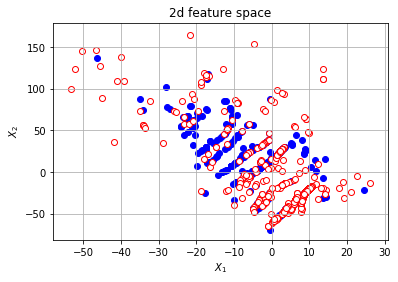

In [304]:
from sklearn import linear_model, decomposition
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_2d_dataset_manifold_learning(X, class_1, class_2, manifold_algorithm):
    title = "2d feature space"
    plt.title(title)
    plt.xlabel("$X_1$")
    plt.ylabel("$X_2$")

    X_trans = manifold_algorithm.fit_transform(X)
    X_1 = X_trans[class_1]
    X_2 = X_trans[class_2]
    plt.scatter(X_1[:, 0], X_1[:, 1], edgecolor="blue", facecolor="blue")
    plt.scatter(X_2[:, 0], X_2[:, 1], edgecolor="red", facecolor="white")

    plt.grid(True)
    plt.show()

def plot_3d_dataset_manifold_learning(train_X, class_1, class_2, manifold_algorithm):
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.set_xlabel("$X_1$")
    ax.set_xlabel("$X_2$")
    ax.set_xlabel("$X_3$")

    X_trans = manifold_algorithm.fit_transform(train_X)
    X_1 = X_trans[class_1]
    X_2 = X_trans[class_2]
    ax.plot(X_1[:, 0], X_1[:, 1], X_1[:, 2], "o", color="blue")
    ax.plot(X_2[:, 0], X_2[:, 1], X_2[:, 2], "o", color="red")

    plt.show()

# X = StandardScaler().fit_transform(train_X)
# selector = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42), threshold='median')
# selector.fit(X, train_y)
# X = selector.transform(X)
metric_learn = ITML_Supervised(num_constraints=1000)
metric_learn.fit(X, train_y)
X = metric_learn.transform(X)

plot_2d_dataset_manifold_learning(X, train_y == 1, train_y == 0, MDS(n_components=2))

In [248]:
X_trans = MDS(n_components=2).fit_transform(train_X)

In [112]:
columns

['Survived',
 'Pclass',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Embarked',
 'Title',
 'Cabin',
 'Fare',
 'FamilySize',
 'IsAlone',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [113]:
columns.index('Sex')-1

1